In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../pylib-main')
from anatomy.anatomy_config import REGION671
import json
from file_io import load_image

In [2]:
tree_json_path = 'tree_yzx.json'
with open(tree_json_path, 'r') as file:
    tree_json = json.load(file) 

In [3]:
brain_to_id = {}
id_to_brain = {}
brain_id_path = {}
for i in range(len(tree_json)):
    bid = tree_json[i]['id']
    acronym = tree_json[i]['acronym']
    p = tree_json[i]['structure_id_path']
    if bid not in brain_to_id:
        brain_to_id[bid] = acronym
        id_to_brain[acronym] = bid
    if bid not in brain_id_path:
        brain_id_path[bid] = p   

In [4]:
major_BS = [688,549,623,313,1065,512,1097]
major_BS_name = ['CTX','TH','CNU','MB','HB','CB','HY','others']
region_Rough = {}
for i in REGION671:
    tmp_p = brain_id_path[i]
    flag = False
    for j in range(len(major_BS)):
        if major_BS[j] in tmp_p:
            region_Rough[brain_to_id[i]] = major_BS_name[j]
            flag = True
    if flag == False:
        region_Rough[brain_to_id[i]] = major_BS_name[len(major_BS_name)-1]

In [5]:
parc_id_table_path = 'gene/parcellation_to_parcellation_term_membership_acronym.csv'
parc_id_table = pd.read_csv(parc_id_table_path)

In [6]:
id_parc_match = {}
for i in range(len(parc_id_table)):
    id_parc_match[parc_id_table['substructure'].iloc[i]] = parc_id_table['parcellation_index'].iloc[i]

In [7]:
c1_table_path = 'gene/cell_metadata_with_cluster_annotation_1.csv'
# c2_table_path = 'gene/cell_metadata_with_cluster_annotation_2.csv'
# c3_table_path = 'gene/cell_metadata_with_cluster_annotation_3.csv'
# c4_table_path = 'gene/cell_metadata_with_cluster_annotation_4.csv'
c1_table = pd.read_csv(c1_table_path)
# c2_table = pd.read_csv(c2_table_path)
# c3_table = pd.read_csv(c3_table_path)
# c4_table = pd.read_csv(c4_table_path)

In [8]:
T1 = pd.read_csv('gene/screened_info1.csv')
# T2 = pd.read_csv('gene/screened_info2.csv')
# T3 = pd.read_csv('gene/screened_info3.csv')
# T4 = pd.read_csv('gene/screened_info4.csv')

In [38]:
G1 = pd.read_csv('gene/screened1_matrix.csv')

In [39]:
col_s = G1.columns[1:1123]

In [10]:
NSC = len(np.unique(c1_table['subclass']))

### Moran & Feature STD comparison between CCFv3 & Sub-parcellation

##### Check distribution of gene subclasses 

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

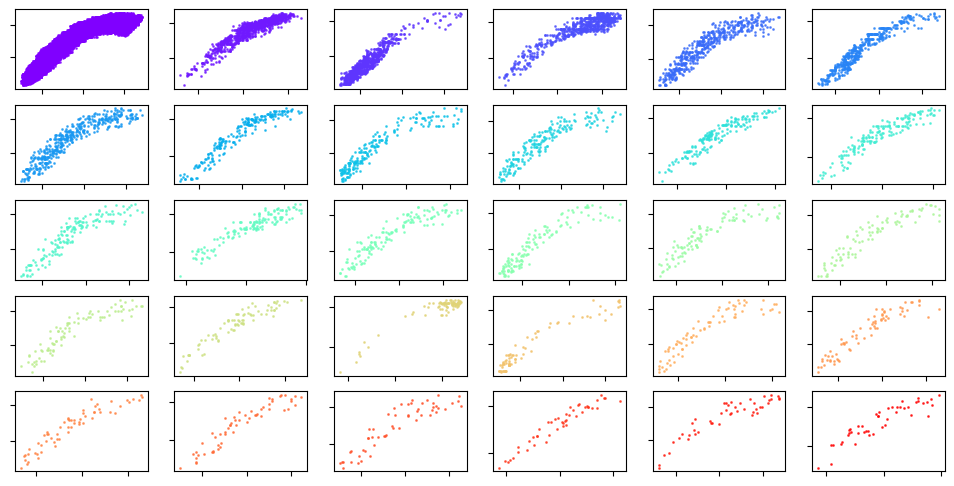

In [32]:
region_id =943
mask_path = 'output_full_r671/parc_region'+str(region_id)+'.nrrd'
parc_mask_tmp = load_image(mask_path)
acronym_name = brain_to_id[region_id]
if acronym_name not in id_parc_match:
    acronym_name = acronym_name+"-unassigned"
r_name = id_parc_match[acronym_name]

t_tmp_df = T1[T1['parcellation_index']==r_name]
s_names = np.array(t_tmp_df['cell_label'])
c_tmp_df = c1_table[c1_table['cell_label'].isin(s_names)]
R_df_tmp = pd.merge(c_tmp_df,t_tmp_df,on='cell_label')
for j in range(2,5):
    tmp_table = eval('c'+str(j)+'_table')
    tmp_T = eval('T'+str(j))
    t_tmp_df = tmp_T[tmp_T['parcellation_index']==r_name]
    s_names = np.array(t_tmp_df['cell_label'])
    c_tmp_df = tmp_table[tmp_table['cell_label'].isin(s_names)]
    s_rows = pd.merge(c_tmp_df,t_tmp_df,on='cell_label')
    R_df_tmp = pd.concat([R_df_tmp,s_rows])
    del s_rows

R_df_tmp['x_y'] = round(R_df_tmp['x_y']*40).astype(int)
R_df_tmp['y_y'] = round(R_df_tmp['y_y']*40).astype(int)
R_df_tmp['z_y'] = round(R_df_tmp['z_y']*40)
R_df_tmp['z_y'] = R_df_tmp['z_y'].apply(lambda x: 456-x if x<228 else x)
R_df_tmp['z_y'] = R_df_tmp['z_y'].astype(int)

parc_labels = parc_mask_tmp[R_df_tmp['z_y'],R_df_tmp['y_y'],R_df_tmp['x_y']]

num_cluster = len(np.unique(R_df_tmp[parc_labels != 0]['cluster']))

cmap = mpl.cm.rainbow
color_s = cmap(np.linspace(0,1,30))
color_s2 = [mpl.colors.rgb2hex(i,keep_alpha=False) for i in color_s]

fig = plt.figure(figsize=(12,6))
count_c = R_df_tmp.value_counts(subset='cluster',sort=True).to_frame()

# n=1
for i in range(30):
    tmp_c = R_df_tmp[R_df_tmp['cluster']==count_c.index[i]]
    # if len(tmp_c) < 50:
    #     continue
    # ax = fig.add_subplot(2,5,n)
    # ax.scatter(tmp_c['x_y'],tmp_c['y_y'],s=1,
    #         marker='o',alpha=0.7,c=color_s2[n-1])
    # ax.set(xticklabels=[],yticklabels=[])
    ax2 = fig.add_subplot(5,6,i+1)
    ax2.scatter(tmp_c['y_y'],tmp_c['z_y'],s=1,
               marker='o',alpha=0.7,c=color_s2[i])
    ax2.set(xticklabels=[],yticklabels=[])
    # n += 1

##### Moran & STD Calculation

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [13]:
from esda.moran import Moran
import pysal.lib as pslib
# import warnings
from scipy.spatial import distance_matrix
def moran_calc2(num_cluster,labels, coords):
    # warnings.filterwarnings('ignore',category=UserWarning)
    N = len(coords)
    if N > 60000:    
        ids = [10*i for i in range(int(np.floor(N/10)))]
        coords = coords[ids,:]
        labels = np.array(labels)[ids]
    dist_m = distance_matrix(coords,coords)
    thres = np.percentile(dist_m,25)
    weights = pslib.weights.DistanceBand.from_array(coords, threshold=thres)
    moran = Moran(labels, weights)
    avgI = moran.I
    pI = moran.p_norm
    zI = moran.z_norm
    return avgI,pI,zI

In [41]:
%%capture

moran_func = False
if moran_func:
    moran_r, moran_scores,moran_r_parc, moran_scores_parc, moran_parc_ids = [],[],[],[],[]
else:
    std_r, std_scores,std_r_parc, std_scores_parc, std_parc_ids, std_delta_parc = [],[],[],[],[],[]

for i in REGION671:
    mask_path = 'lyf/output_full_r671/parc_region'+str(i)+'.nrrd'
    if not os.path.exists(mask_path):
        continue
    parc_mask_tmp = load_image(mask_path)
    N_parc = np.max(parc_mask_tmp)
    if N_parc <2:
        continue
    region_id = i
    acronym_name = brain_to_id[region_id]
    if acronym_name not in id_parc_match:
        acronym_name = acronym_name+"-unassigned"
    if acronym_name not in id_parc_match:
        continue
    r_name = id_parc_match[acronym_name]
    
    if moran_func:
        t_tmp_df = T1[T1['parcellation_index']==r_name]
        if len(t_tmp_df) < 10:
            continue
        s_names = np.array(t_tmp_df['cell_label'])
        c_tmp_df = c1_table[c1_table['cell_label'].isin(s_names)]
        R_df_tmp = pd.merge(c_tmp_df,t_tmp_df,on='cell_label')
        coords = R_df_tmp[['x_y','y_y','z_y']].values
        R_df_tmp['x_y'] = round(R_df_tmp['x_y']*40).astype(int)
        R_df_tmp['y_y'] = round(R_df_tmp['y_y']*40).astype(int)
        R_df_tmp['z_y'] = round(R_df_tmp['z_y']*40)
        R_df_tmp['z_y'] = R_df_tmp['z_y'].apply(lambda x: 456-x if x<228 else x)
        R_df_tmp['z_y'] = R_df_tmp['z_y'].astype(int)    
        g_labels = R_df_tmp['cluster'].apply(lambda x: int(x.split(' ')[0]))
        num_cluster = len(np.unique(g_labels))
        
        parc_labels = parc_mask_tmp[R_df_tmp['z_y'],R_df_tmp['y_y'],R_df_tmp['x_y']]
    
        moran_score,moran_pi,moran_zi = moran_calc2(num_cluster,g_labels, coords)
        moran_scores.append(moran_score)
        moran_r.append(brain_to_id[region_id])  
        
        del t_tmp_df,c_tmp_df,R_df_tmp, parc_mask_tmp
    else:
        t_tmp_df = G1[G1['parcellation_index']==r_name]
        if len(t_tmp_df) < 10:
            continue

        R_df_tmp = t_tmp_df

        R_df_tmp['x'] = round(R_df_tmp['x']*40).astype(int)
        R_df_tmp['y'] = round(R_df_tmp['y']*40).astype(int)
        R_df_tmp['z'] = round(R_df_tmp['z']*40)
        R_df_tmp['z'] = R_df_tmp['z'].apply(lambda x: 456-x if x<228 else x)
        R_df_tmp['z'] = R_df_tmp['z'].astype(int)

        parc_labels = parc_mask_tmp[R_df_tmp['z'],R_df_tmp['y'],R_df_tmp['x']]
     
        ss = StandardScaler()
        R_df_scaled = ss.fit_transform(R_df_tmp[col_s])
        pca = PCA(n_components=3)
        R_df_trans = pca.fit_transform(R_df_scaled)
        std_r.append(brain_to_id[region_id])
        top_std = np.std(R_df_trans,axis=0)
        std_scores.append(np.mean(top_std))
    
        del t_tmp_df,R_df_tmp,parc_mask_tmp
    
    for j in range(1,N_parc+1):
        if moran_func:
            g2 = g_labels[parc_labels == j]
            if len(g2) <10:
                continue
            num_cluster_tmp = len(np.unique(g2))
            coords_tmp = coords[parc_labels == j,:]
            moran_score2,moran_pi2,moran_zi2 = moran_calc2(num_cluster_tmp,g2, coords_tmp)
            moran_scores_parc.append(moran_score2)
            moran_parc_ids.append(j)
            moran_r_parc.append(brain_to_id[region_id])
            
            del coords_tmp
        else: 
            tmp_rows = R_df_trans[parc_labels == j]
            if len(tmp_rows) <10:
                continue
            std_r_parc.append(brain_to_id[region_id])
            std_parc_ids.append(j)
        
            top_std_tmp = np.std(tmp_rows,axis=0)
            std_scores_parc.append(np.mean(top_std_tmp))
            std_delta_parc.append(np.mean(top_std_tmp)-np.mean(top_std))
            del tmp_rows

In [16]:
def load_features(mefile, scale=25., feat_type='mRMR', flipLR=True):
    df = pd.read_csv(mefile, index_col=0, comment='#')
    
    if feat_type == 'full':
        cols = df.columns
        fnames = [fname for fname in cols if fname[-3:] == '_me']
    elif feat_type == 'mRMR':
        # Features selected by mRMR
        fnames = mRMR_f3me
    elif feat_type == 'PCA':
        fnames = ['pca_feat1', 'pca_feat2', 'pca_feat3']
    else:
        raise ValueError("Unsupported feature types")

    # standardize
    tmp = df[fnames]
    tmp = (tmp - tmp.mean()) / (tmp.std() + 1e-10)
    df[fnames] = tmp

    # scaling the coordinates to CCFv3-25um space
    df['soma_x'] /= scale
    df['soma_y'] /= scale
    df['soma_z'] /= scale
    # we should remove the out-of-region coordinates
    zdim,ydim,xdim = (456,320,528)   # dimensions for CCFv3-25um atlas
    in_region = (df['soma_x'] >= 0) & (df['soma_x'] < xdim) & \
                (df['soma_y'] >= 0) & (df['soma_y'] < ydim) & \
                (df['soma_z'] >= 0) & (df['soma_z'] < zdim)
    df = df[in_region]
    print(f'Filtered out {in_region.shape[0] - df.shape[0]}')

    if flipLR:
        # mirror right hemispheric points to left hemisphere
        zdim2 = zdim // 2
        nzi = (df['soma_z'] < zdim2).values.nonzero()
        loci = df.index[nzi]
        df.loc[loci, 'soma_z'] = zdim - df.loc[loci, 'soma_z']

    return df, fnames

In [17]:
me_file_path = 'BrainParcellation/microenviron/data/mefeatures_100K_with_PCAfeatures3.csv'
me_df_new, fnames_new = load_features(me_file_path, scale=25., feat_type='full', flipLR=True)

Filtered out 0


In [18]:
import pymrmr

In [19]:
### L2/3
def moran_calc_me(df, fnames):
    coords = df[['soma_x', 'soma_y', 'soma_z']]/40
    dist_m = distance_matrix(coords,coords)
    thres = np.percentile(dist_m,25)
    weights = pslib.weights.DistanceBand.from_array(coords.values, threshold=thres,binary=True)
    avgI = []
    pI = []
    zI = []
    for fn in fnames:
        moran = Moran(df[fn], weights)
        avgI.append(moran.I)
        pI.append(moran.p_norm)
        zI.append(moran.z_norm)
    return avgI,pI,zI

In [42]:
%%capture
moran_func2 = False
if moran_func2:
    moran_regions,moran_parcID,moran_I_all,moran_me_I,moran_me_r= [],[],[],[],[]
else:
    fstd_regions,fstd_parcID,fstd_I_all,fstd_me_I,fstd_me_r,fstd_delta_all= [],[],[],[],[],[]

for i in REGION671:
    mask_file = 'lyf/output_full_r671/parc_region'+str(i)+'.nrrd'
    if os.path.exists(mask_file):
        mask = load_image(mask_file)
        N_parc = np.max(mask)
        
        me_df_r = me_df_new[me_df_new['region_id_r671']==i]
        print(len(me_df_r))
        if len(me_df_r) < 10:
            continue
        if N_parc <2:
            continue
        
        me_df_r2 = me_df_r.copy()
        me_df_r2['soma_z'] = round(me_df_r2['soma_z']).astype(int)
        me_df_r2['soma_x'] = round(me_df_r2['soma_x']).astype(int)
        me_df_r2['soma_y'] = round(me_df_r2['soma_y']).astype(int)
    
        parc_labels = mask[me_df_r2['soma_z'],me_df_r2['soma_y'],me_df_r2['soma_x']]
        
        del mask
        
        if moran_func2:
            me_df_r2 = me_df_r2[fnames_new]
            me_df_r2.insert(loc=0,column='parc_id',value=parc_labels)
        
            mrmr_F = pymrmr.mRMR(me_df_r2,'MIQ',3)
        
            avgI_me,pI_me,zI_me = moran_calc_me(me_df_r, mrmr_F)
            moran_me_I.append(np.mean(avgI_me))
            moran_me_r.append(brain_to_id[i]) 
                
        else:
            tmp_scaled = StandardScaler().fit_transform(me_df_r[fnames_new])
        
            pca = PCA(n_components=3)
            tmp_trans = pca.fit_transform(tmp_scaled)
            top_std = np.std(tmp_trans,axis=0)
            meanSTD = np.mean(top_std)
            fstd_me_I.append(meanSTD)
            fstd_me_r.append(brain_to_id[i]) 
            del tmp_scaled

        for j in range(1,N_parc+1):
            if len(me_df_r[parc_labels == j]) < 10:
                continue
            
            if moran_func2:
                me_tmp = me_df_r[parc_labels == j]            
                avgI,pI,zI = moran_calc_me(me_tmp, mrmr_F)
                
                moran_I_all.append(np.mean(avgI))
                moran_regions.append(brain_to_id[i])
                moran_parcID.append(j)
                
                del me_tmp
            else:
                me_tmp = tmp_trans[parc_labels==j,:]
                top_std_tmp = np.std(me_tmp,axis=0)
                fstd_I_all.append(np.mean(top_std_tmp))
                fstd_regions.append(brain_to_id[i])
                fstd_parcID.append(j)
                fstd_delta_all.append(np.mean(top_std_tmp) - meanSTD)
                
                del me_tmp
        del me_df_r, me_df_r2

In [24]:
### match rows
moran_I_all2 = []
moran_R_full2 = []
moran_me_I2 = []
moran_me_R2 = []
keep_r_ids = []
n = 0
keep_parc_ids = []
for i in moran_r:
    if i in moran_me_r:
        moran_me_I2.append(moran_me_I[moran_me_r.index(i)])
        moran_me_R2.append(region_Rough[i])
        ids_tmp = np.where(np.array(moran_regions)==i)[0]
        ids_tmp2 = np.where(np.array(moran_r_parc)==i)[0]
        p_tmp = np.array(moran_parcID)[ids_tmp]
        p_tmp2 = np.array(moran_parc_ids)[ids_tmp2]
        ids_set = set(p_tmp).intersection(set(p_tmp2))
        tmp_p = []
        for k in list(ids_set):
            tmp_p.append(ids_tmp[np.where(p_tmp == k)[0][0]])
        for j in tmp_p:
            moran_I_all2.append(moran_I_all[j])
            moran_R_full2.append(region_Rough[i])
            keep_parc_ids.append(ids_tmp2[np.where(p_tmp2 == moran_parcID[j])[0][0]])
        keep_r_ids.append(n)
    n += 1

In [45]:

### match rows
fstd_I_all2 = []
fstd_R_full2 = []
fstd_me_I2 = []
fstd_me_R2 = []
keep_r_ids2 = []
fstd_delta_all2 = []
n = 0
keep_parc_ids2 = []
for i in std_r:
    if i in fstd_me_r:
        fstd_me_I2.append(fstd_me_I[fstd_me_r.index(i)])
        fstd_me_R2.append(region_Rough[i])
        ids_tmp = np.where(np.array(fstd_regions)==i)[0]
        ids_tmp2 = np.where(np.array(std_r_parc)==i)[0]
        p_tmp = np.array(fstd_parcID)[ids_tmp]
        p_tmp2 = np.array(std_parc_ids)[ids_tmp2]
        ids_set = set(p_tmp).intersection(set(p_tmp2))
        tmp_p = []
        for k in list(ids_set):
            tmp_p.append(ids_tmp[np.where(p_tmp == k)[0][0]])
        for j in tmp_p:
            fstd_I_all2.append(fstd_I_all[j])
            fstd_R_full2.append(region_Rough[i])
            fstd_delta_all2.append(fstd_delta_all[j])
            keep_parc_ids2.append(ids_tmp2[np.where(p_tmp2 == fstd_parcID[j])[0][0]])
        keep_r_ids2.append(n)
    n += 1

In [25]:
moran_r2 = np.array(moran_r)[keep_r_ids]
moran_scores2 = np.array(moran_scores)[keep_r_ids]
moran_r_parc2 = np.array(moran_r_parc)[keep_parc_ids]
moran_scores_parc2 = np.array(moran_scores_parc)[keep_parc_ids]

In [26]:
moran_R = []
for i in moran_r2:
    moran_R.append(region_Rough[i])
moran_R = np.array(moran_R)
moran_R2 = []
for i in moran_r_parc2:
    moran_R2.append(region_Rough[i])
moran_R2 = np.array(moran_R2)

In [27]:
moran_scores[np.where(moran_r2=='PIR')[0][0]]

0.008923049383802858

In [28]:
moran_R_full2 = np.array(moran_R_full2)
moran_me_R2 = np.array(moran_me_R2)

##### Plot

In [29]:
cmap = mpl.cm.rainbow
color_hm = cmap(np.linspace(0,1,len(major_BS_name)-1))
color_hm2 = [mpl.colors.rgb2hex(i,keep_alpha=False) for i in color_hm]

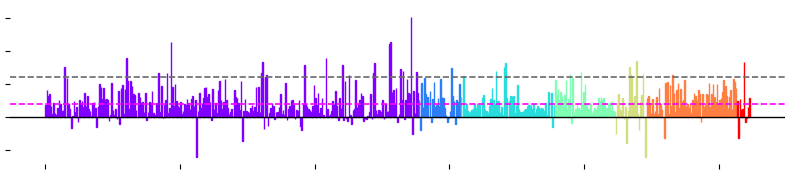

In [31]:
plt.figure(figsize=(10,2))
current = 0.5
for i in range(len(major_BS_name)-1):
    score_tmp = np.array(moran_I_all2)[moran_R_full2==major_BS_name[i]]
    score_tmp = score_tmp*100
    # score_tmp = list(score_tmp)
    bin_positions = np.arange(current,len(score_tmp)+current)
    plt.bar(bin_positions,score_tmp,width =0.5,color = color_hm2[i],align='center',edgecolor=color_hm2[i])
    current += len(score_tmp)
# plt.xlabel('Moran I',fontsize=15)
# plt.ylabel('#Sub-parcellation',fontsize=15)
plt.axhline(10,color='magenta',linestyle='--',linewidth=1.2)
plt.axhline(30,color='dimgray',linestyle='--',linewidth=1.2)
plt.axhline(0,color='black',linewidth=1)
plt.tick_params(labelbottom=False,labelleft=False)
ax = plt.gca()
for spine in ['left','right','top','bottom']:
    ax.spines[spine].set_visible(False)
plt.savefig('all_figs/Fig5/moran_me_parcs.png',dpi=300)

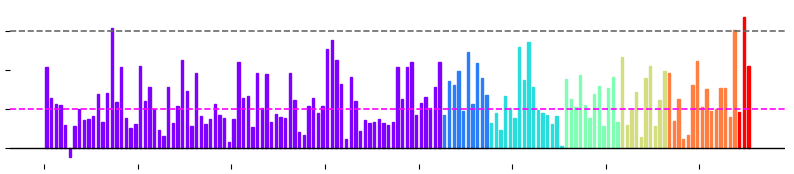

In [33]:
plt.figure(figsize=(10,2))
current = 0.5
for i in range(len(major_BS_name)-1):
    score_tmp = np.array(moran_me_I2)[moran_me_R2==major_BS_name[i]]
    score_tmp = score_tmp*100
    bin_positions = np.arange(current,len(score_tmp)+current)
    plt.bar(bin_positions,score_tmp,width =0.5,color = color_hm2[i],align='center',edgecolor=color_hm2[i])
    current += len(score_tmp)
# plt.xlabel('Moran I',fontsize=15)
# plt.ylabel('#Sub-parcellation',fontsize=15)
plt.axhline(10,color='magenta',linestyle='--',linewidth=1.2)
plt.axhline(30,color='dimgray',linestyle='--',linewidth=1.2)
plt.axhline(0,color='black',linewidth=1)
plt.tick_params(labelbottom=False,labelleft=False)
ax = plt.gca()
for spine in ['left','right','top','bottom']:
    ax.spines[spine].set_visible(False)
plt.savefig('all_figs/Fig5/moran_me_regions.png',dpi=300)

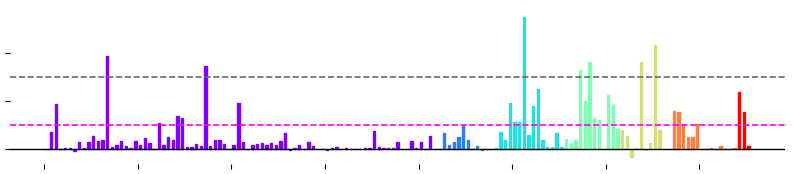

In [35]:
plt.figure(figsize=(10,2))
current = 0.5
for i in range(len(major_BS_name)-1):
    score_tmp = np.array(moran_scores2)[moran_R==major_BS_name[i]]
    score_tmp = score_tmp*100
    # score_tmp = list(score_tmp)
    bin_positions = np.arange(current,len(score_tmp)+current)
    plt.bar(bin_positions,score_tmp,width =0.5,color = color_hm2[i],align='center',edgecolor=color_hm2[i])
    current += len(score_tmp)
# plt.xlabel('Moran I',fontsize=15)
# plt.ylabel('#Sub-parcellation',fontsize=15)
plt.axhline(10,color='magenta',linestyle='--',linewidth=1.2)
plt.axhline(30,color='dimgray',linestyle='--',linewidth=1.2)
plt.axhline(0,color='black',linewidth=1)
plt.tick_params(labelbottom=False,labelleft=False)
ax = plt.gca()
for spine in ['left','right','top','bottom']:
    ax.spines[spine].set_visible(False)
plt.savefig('all_figs/Fig5/moran_regions.png',dpi=300)

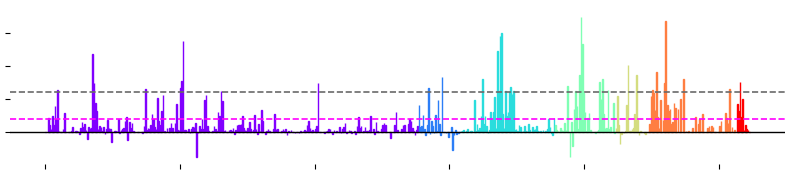

In [37]:
plt.figure(figsize=(10,2))
current = 0.5
for i in range(len(major_BS_name)-1):
    score_tmp = np.array(moran_scores_parc2)[moran_R2==major_BS_name[i]]
    score_tmp = score_tmp*100
    # score_tmp = list(score_tmp)
    bin_positions = np.arange(current,len(score_tmp)+current)
    plt.bar(bin_positions,score_tmp,width =0.5,color = color_hm2[i],align='center',edgecolor=color_hm2[i])
    current += len(score_tmp)
# plt.xlabel('Moran I',fontsize=15)
# plt.ylabel('#Sub-parcellation',fontsize=15)
plt.axhline(10,color='magenta',linestyle='--',linewidth=1.2)
plt.axhline(30,color='dimgray',linestyle='--',linewidth=1.2)
plt.axhline(0,color='black',linewidth=1)
plt.tick_params(labelbottom=False,labelleft=False)
ax = plt.gca()
for spine in ['left','right','top','bottom']:
    ax.spines[spine].set_visible(False)
plt.savefig('all_figs/Fig5/moran_parc_regions.png',dpi=300)

In [46]:
std_r2 = np.array(std_r)[keep_r_ids2]
std_scores2 = np.array(std_scores)[keep_r_ids2]
std_r_parc2 = np.array(std_r_parc)[keep_parc_ids2]
std_scores_parc2 = np.array(std_scores_parc)[keep_parc_ids2]
std_delta_parc2 = np.array(std_delta_parc)[keep_parc_ids2]

In [47]:
np.array(fstd_delta_all2)[np.array(fstd_delta_all2)<=0].shape,len(fstd_delta_all2)

((443,), 523)

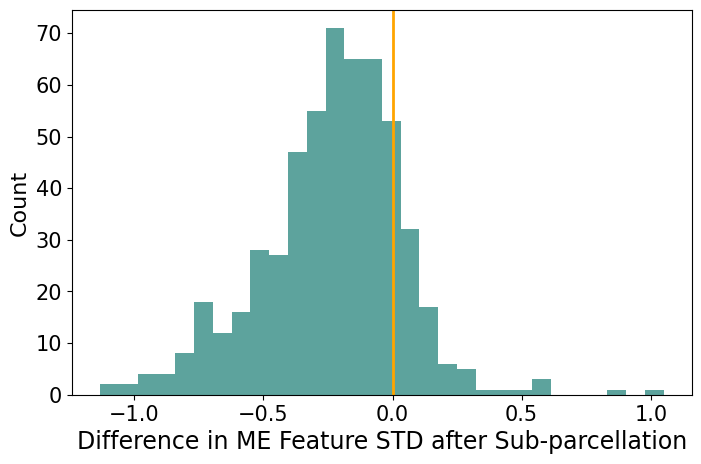

In [52]:

plt.figure(figsize=(8,5))
plt.hist(fstd_delta_all,bins=30,color= '#5DA39D')
plt.xlabel('Difference in ME Feature STD after Sub-parcellation',fontsize=17)
plt.ylabel('Count',fontsize=16)
plt.tick_params(labelsize=15)
plt.axvline(0,color='orange',linewidth=2)
plt.savefig('all_figs/Fig5/fstd_delta.png',dpi=300,bbox_inches='tight')

In [53]:
np.array(std_delta_parc2)[np.array(std_delta_parc2)<=0].shape,len(std_delta_parc2)

((361,), 523)

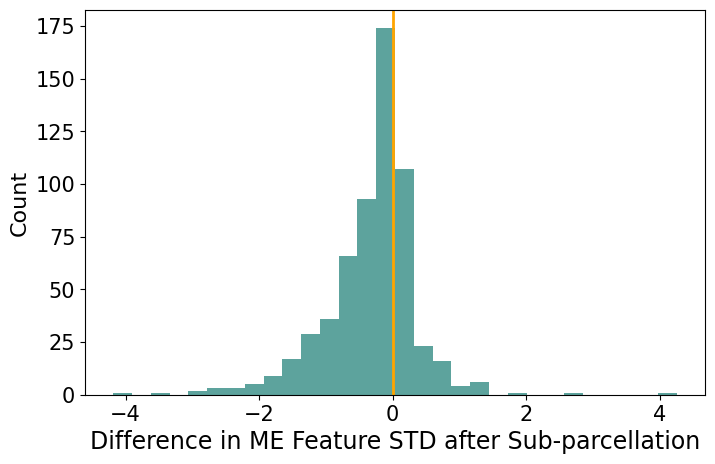

In [54]:
plt.figure(figsize=(8,5))
plt.hist(std_delta_parc,bins=30,color= '#5DA39D')
plt.xlabel('Difference in ME Feature STD after Sub-parcellation',fontsize=17)
plt.ylabel('Count',fontsize=16)
plt.tick_params(labelsize=15)
plt.axvline(0,color='orange',linewidth=2)
plt.savefig('all_figs/Fig5/std_delta.png',dpi=300,bbox_inches='tight')

In [29]:
out_gene_moran = pd.DataFrame({'region':moran_r2,'moranI':moran_scores2})
out_gene_moran.to_csv('gene/moranI_geneLabel.csv',index=None)

##### Sub-region Centroid Point

In [52]:
def compute_centroids(mask):
    centroids = []
    for i in range(1,np.max(mask)+1):
        f = mask==i
        smask = mask.copy()
        smask.fill(0)
        smask[f] = mask[f]
        nzcds = smask.nonzero()
        nzcds_t = np.array(nzcds).transpose()
        c = nzcds_t.mean(axis=0)
        centroids.append(c*25)
    return np.array(centroids)

In [55]:
region_name = 'PIR'
mask_file = 'lyf/output_full_r671/parc_region'+str(id_to_brain[region_name])+'.nrrd'
mask = load_image(mask_file)
coords = me_df[me_df['region_name_r671']==region_name][['soma_x','soma_y', 'soma_z']].values
x = [int(round(x/25)) for x in coords[:,0]]
y = [int(round(x/25)) for x in coords[:,1]]
z = np.round(coords[:,2]/25)
z = [456-x if x<228 else x for x in z]
z = [int(x) for x in z]
labels = mask[z,y,x]
labels = np.array(labels)
s_me_rows = me_df[me_df['region_name_r671']==region_name]
centroids = compute_centroids(mask)
len(centroids)

6

In [62]:
r = 90
nid = 3
c = centroids[nid]
s_me_rows[(labels==(nid+1))&(c[0]-r<s_me_rows['soma_z'])&(s_me_rows['soma_z']<c[0]+r)
          &(c[1]-r<s_me_rows['soma_y'])&(s_me_rows['soma_y']<c[1]+r)&
          (c[2]-r<s_me_rows['soma_x'])&(s_me_rows['soma_x']<c[2]+r)]
# s_me_rows[(c[0]-r<s_me_rows['soma_z'])&(s_me_rows['soma_z']<c[0]+r)
#           &(c[1]-r<s_me_rows['soma_y'])&(s_me_rows['soma_y']<c[1]+r)&
#           (c[2]-r<s_me_rows['soma_x'])&(s_me_rows['soma_x']<c[2]+r)]

,Nodes,SomaSurface,Stems,Bifurcations,Branches,Tips,OverallWidth,OverallHeight,OverallDepth,AverageDiameter,...,pc12_me,pc13_me,pca_vr1_me,pca_vr2_me,pca_vr3_me,pca_feat1,pca_feat2,pca_feat3,region_name_r671,region_id_r671
13228_13246_3042,316,1017.88,3,13,27,15,146.6,151.2,129.775,3.4981,...,0.139734,-0.480224,0.521396,0.288427,0.190179,-1.207588,-0.19111,2.206507,PIR,961


##### Feature Plot

In [61]:
## features 
feature_name = me_df.columns[34:58]

In [371]:
region_compared_spec = []
key_word = 'MOp'
for i in ['1','2/3','4','5','6a','6b']:
    region_compared_spec.append(key_word+i)

In [364]:
region_compared_spec = ['MOp2/3']

In [365]:
%%capture
me_compared_df = pd.DataFrame()
for r in region_compared_spec:
    if r not in id_to_brain:
        continue
    mask_file = 'lyf/output_full_r671/parc_region'+str(id_to_brain[r])+'.nrrd'
    mask = load_image(mask_file)
    df = me_df[me_df['region_name_r671']==r]
    coords = df[['soma_x','soma_y', 'soma_z']].values
    x = [int(round(x/25)) for x in coords[:,0]]
    y = [int(round(x/25)) for x in coords[:,1]]
    z = np.round(coords[:,2]/25)
    z = [456-x if x<228 else x for x in z]
    z = [int(x) for x in z]
    labels = mask[z,y,x]
    for i in range(1,1+np.max(mask)):
        df_s = df[labels==i]
        if len(df_s) == 0:
            continue
        df_s['parc_id'] = [i for j in range(len(df_s))]
        df_s['label'] = [r+'-'+str(i) for j in range(len(df_s))]
        feature_name_mean = []
        for k in feature_name:
            name = 'mean_'+k
            mean_F = df_s[k].mean()
            df_s[name] = [mean_F for j in range(len(df_s))]
            feature_name_mean.append(name)
        c = list(feature_name) + feature_name_mean + ['region_name_r671','parc_id','label']
        me_compared_df = pd.concat([me_compared_df,df_s[c]])

In [340]:
nzcoords = mask.nonzero()
nzcoords_t = np.array(nzcoords).transpose()
nzcoords_t.min(axis=0),nzcoords_t.max(axis=0)

(array([274, 172, 117]), array([417, 296, 333]))

In [367]:
r_name = 'MOp2/3'
df_tmp = me_compared_df[me_compared_df['region_name_r671']==r_name]

In [80]:
tmp = df_tmp[list(feature_name)]
tmp2 = (tmp-np.mean(tmp,axis=0))/np.std(tmp,axis=0)
pca = PCA()
pca.fit(tmp2)
pcs = pca.components_
pc_f_df = pd.DataFrame(pcs.T,columns=[f'PC{i+1}' for i in range(pcs.shape[0])],
                       index=feature_name)

In [368]:
tmp = df_tmp[list(feature_name)]
tmp2 = (tmp-np.mean(tmp,axis=0))/np.std(tmp,axis=0)
tmp2.insert(0,'parc_id',list(df_tmp['parc_id']))
pymrmr.mRMR(tmp2,'MIQ',8)



 *** This program and the respective minimum Redundancy Maximum Relevance (mRMR) 
     algorithm were developed by Hanchuan Peng <hanchuan.peng@gmail.com>for
     the paper 
     "Feature selection based on mutual information: criteria of 
      max-dependency, max-relevance, and min-redundancy,"
      Hanchuan Peng, Fuhui Long, and Chris Ding, 
      IEEE Transactions on Pattern Analysis and Machine Intelligence,
      Vol. 27, No. 8, pp.1226-1238, 2005.



['AverageParent-daughterRatio_me',
 'OverallWidth_me',
 'AverageFragmentation_me',
 'pc11_me',
 'Volume_me',
 'Stems_me',
 'OverallHeight_me',
 'HausdorffDimension_me']


*** MaxRel features ***
Order 	 Fea 	 Name 	 Score
1 	 15 	 AverageParent-daughterRatio_me 	 0.134
2 	 5 	 OverallWidth_me 	 0.102
3 	 9 	 Volume_me 	 0.072
4 	 14 	 AverageFragmentation_me 	 0.070
5 	 6 	 OverallHeight_me 	 0.064
6 	 2 	 Bifurcations_me 	 0.059
7 	 7 	 OverallDepth_me 	 0.058
8 	 4 	 Tips_me 	 0.057

*** mRMR features *** 
Order 	 Fea 	 Name 	 Score
1 	 15 	 AverageParent-daughterRatio_me 	 0.134
2 	 5 	 OverallWidth_me 	 2.289
3 	 14 	 AverageFragmentation_me 	 1.405
4 	 19 	 pc11_me 	 1.249
5 	 9 	 Volume_me 	 1.159
6 	 1 	 Stems_me 	 1.098
7 	 6 	 OverallHeight_me 	 0.957
8 	 18 	 HausdorffDimension_me 	 0.916


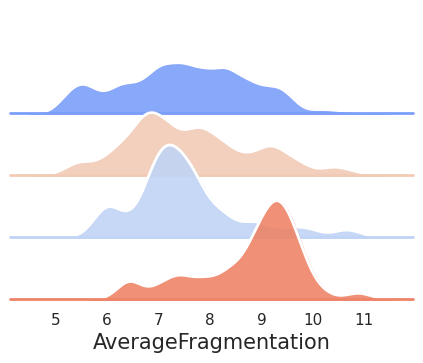

In [389]:
F = 'AverageFragmentation_me'
F2 = 'mean_'+F
sns.set_theme(style="white",rc={"axes.facecolor":(0,0,0,0)})
pal = sns.color_palette(palette='coolwarm',n_colors=np.unique(df_tmp['label']).shape[0])
g = sns.FacetGrid(df_tmp, row='label',hue=F2,
                  aspect=5,height=1,palette=pal)

g.map(sns.kdeplot,F,bw_adjust=0.5,clip_on=False,fill=True,
      alpha=0.9,linewidth=1.5)
g.map(sns.kdeplot,F,clip_on=False,color='w',lw=2,bw_adjust=.5)
g.map(plt.axhline,y=0,lw=2,linestyle="-", color=None,clip_on=False)

# for i,ax in enumerate(g.axes.flat):
#       ax.text(-0.1,.1,np.unique(df_tmp['label'])[i],fontsize=15,color=ax.lines[-1].get_color(),
#               transform = ax.transAxes)
# def label(x,color,label):
#       ax = plt.gca()
#       ax.text(0,.2,label,color=color,ha='left',va='center',transform=ax.transAxes)
# g.map(label,'label')
    
g.fig.subplots_adjust(hspace=-0.4)
g.set_ylabels("")
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True,left=True)
plt.setp(ax.get_xticklabels(),fontsize=12)
Ff = F.split('_me')[0]
plt.xlabel(Ff,fontsize=15)
# plt.ticklabel_format(style='sci',axis='x',scilimits=(0,0))
if '/' in r_name:
      r_name2 = r_name.split('/')[0]+r_name.split('/')[1]
else:
      r_name2 = r_name
out_name = 'all_figs/Fig5/'+r_name2+'_'+F+'.png'
plt.savefig(out_name,dpi=300)

##### Pixel Extraction

In [50]:
### points for plot
def pixel_points(parc_mask):
    points = []
    nzcoords = parc_mask.nonzero()
    for i in range(len(nzcoords[0])):
        z = nzcoords[0][i]
        y = nzcoords[1][i]
        x = nzcoords[2][i]
        points.append(np.array([x,y,z,parc_mask[z,y,x]]))
    points = np.array(points).astype(int)
    
    return points

In [51]:
region_name = 'PIR'
mask_file = 'lyf/output_full_r671/parc_region'+str(id_to_brain[region_name])+'.nrrd'
mask = load_image(mask_file)
points = pixel_points(mask)
np.savetxt('pixel_points/PIR.txt',points,fmt='%d')